## Importations et chargement

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
csv_path = 'data/CES19.csv'


In [3]:
df = pd.read_csv(csv_path, index_col=0)
df.head()

df_columns = df.columns

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (25,27,28,30,31,33,34,39,179,181,188,192,193,199,210,227,234,236,237,239,240,243,276,299,302,311,314,315,316,327,362,417,418,421,422,423,424,425,431,464,465,468,538,541,578,579,582,583,584) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
def get_column_names():
    """
    Returns a list of column names
    """
    return df.columns.tolist()

def get_column_value_counts(column_name):
    """
    Returns a df with the value counts of a column
    """
    return df[column_name].value_counts()

def plot_column_values(column_name):
    """
    Plots a column values
    """
    df[column_name].value_counts().plot(kind='bar')
    plt.title(f"Distribution des réponses de la question {column_name}")
    plt.show()

def get_unique_values_per_column(min_unique_threshold=None, max_unique_threshold=None):
    """
    Returns a list of unique values per column with optional minimum threshold
    """
    unique_values = df.nunique()

    if min_unique_threshold:
        unique_values = unique_values[unique_values > min_unique_threshold]
    elif max_unique_threshold:
        unique_values = unique_values[unique_values < max_unique_threshold]

    return unique_values

def get_columns_per_value_keyword(keyword):
    """
    Returns a list of columns with a value containing the keyword
    """
    return df.columns[df.apply(lambda x: keyword in x.values, axis=0)].tolist()

def get_samples_per_column(N=5):
    """
    Returns a sample of non-NaN answers per column if they exist
    """
    samples_per_column = {}
    for column in df.columns:
        non_nan_values = df[column][~df[column].isna()]

        if len(non_nan_values) > N:
            samples_per_column[column] = non_nan_values.sample(N).tolist()

    return samples_per_column


In [5]:
samples_per_column = get_samples_per_column()

samples_per_column

{'cps19_StartDate': ['2019-10-03 03:01:42',
  '2019-10-08 14:50:07',
  '2019-09-23 10:43:40',
  '2019-09-14 07:01:26',
  '2019-10-07 03:55:36'],
 'cps19_EndDate': ['2019-09-29 04:26:54',
  '2019-10-16 14:04:59',
  '2019-09-28 11:31:51',
  '2019-10-20 05:15:17',
  '2019-10-11 04:32:37'],
 'cps19_ResponseId': ['R_tXrSLGeY7Svcu9H',
  'R_31daYvXAgWBHyR8',
  'R_1IfSmBRwmPIeCkB',
  'R_cuufziLNRaAnPY5',
  'R_0wbr1ZPksFdv4LT'],
 'cps19_consent': ['I consent to participate in this study. I have read all of the information about the study.',
  'I consent to participate in this study. I have read all of the information about the study.',
  'I consent to participate in this study. I have read all of the information about the study.',
  'I consent to participate in this study. I have read all of the information about the study.',
  'I consent to participate in this study. I have read all of the information about the study.'],
 'cps19_citizenship': ['Canadian citizen',
  'Canadian citizen',
  'Canad

### Enlever les colonnes ayant plus de 125 réponses uniques

In [6]:
unique_answers_max = 125
columns_with_too_many_unique_answers = get_unique_values_per_column(min_unique_threshold=unique_answers_max)

print(f"\nIl y a {len(columns_with_too_many_unique_answers)} colonnes avec trop de réponses uniques.\n")

# Create another df without those columns
df2 = df.loc[:, [column not in columns_with_too_many_unique_answers for column in df.columns]]


Il y a 47 colonnes avec trop de réponses uniques.



### Enlever les colonnes ayant 0 ou 1 réponse unique

In [7]:
unique_answers_min = 2
columns_without_enough_unique_answers = get_unique_values_per_column(max_unique_threshold=unique_answers_min)

print(f"\nIl y a {len(columns_without_enough_unique_answers)} colonnes avec trop peu de réponses uniques.\n")

# Create another df without those columns
df3 = df2.loc[:, [column not in columns_without_enough_unique_answers for column in df2.columns]]


Il y a 137 colonnes avec trop peu de réponses uniques.



### Enlever les questions jugées non-pertinentes

In [8]:
non_pertinent_columns = [
    "cps19_consent", # La question de consentement à répondre avant de commencer le questionnaire
    
]

print(f"\nIl y a {len(non_pertinent_columns)} colonnes non pertinentes.\n")

df4 = df3.loc[:, [column not in non_pertinent_columns for column in df3.columns]]

df4


Il y a 1 colonnes non pertinentes.



,cps19_citizenship,cps19_yob,cps19_gender,cps19_province,cps19_education,cps19_demsat,cps19_imp_iss_party,cps19_imp_loc_iss_p,cps19_interest_gen_1,cps19_interest_elxn_1,...,split_health_followups,split_gender_id,split_big5,split_hatespeech,split_vol_assoc,pes19_data_quality,pes19_panel,pes19_age,pes19_duplicates_flag,pes19_inattentive
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,Canadian citizen,1989,A woman,Quebec,Master's degree,Fairly satisfied,Green Party,ndp,9.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Canadian citizen,1998,A woman,Quebec,Master's degree,Don't know/ Prefer not to answer,Green Party,ndp,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Canadian citizen,2000,A woman,Ontario,Some university,Fairly satisfied,NaN,NaN,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Canadian citizen,1998,A man,Ontario,Some university,Fairly satisfied,Conservative Party,NaN,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Canadian citizen,2000,A woman,Ontario,Completed secondary/ high school,Fairly satisfied,Don't know/ Prefer not to answer,Conservative Party,8.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37818,Canadian citizen,1961,A man,Quebec,Bachelor's degree,Fairly satisfied,Liberal Party,NaN,7.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,pes19_r,58.0,0.0,0.0
37819,Canadian citizen,1991,A man,Ontario,Bachelor's degree,Not very satisfied,Green Party,NaN,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37820,Canadian citizen,1969,A woman,Saskatchewan,"Some technical, community college, CEGEP, Coll...",Fairly satisfied,ndp,ndp,10.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df4

df[["pes10_socnet3", "pes19_keepromises"]]

,pes10_socnet3,pes19_keepromises
Unnamed: 0,,
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
...,...,...
37818,Less than once a month,Some of the time
37819,NaN,NaN
37820,NaN,NaN


### Trouver les questions à choix multiples non étalées sur plusieurs questions

In [10]:
multiple_choice_question_keywords = ["Very satisfied", "None of these", "Got better", "Fewer immigrants", "Fewer refugees", "Not at all well", "Very opposed", "Fairly strongly", "Some of the time", "Much closer", "A good job", "None at all", "Very comfortable", "Extremely easy", "Weekly", "Sometimes", "Just once", "Much more"]
#print(get_columns_per_value_keyword("Very satisfied"))

# Questions à 7 choix
six_choice_questions = ['pes10_socnet3']
print(f"Il y a {len(six_choice_questions)} questions à 7 choix.")

# Questions à 6 choix
six_choice_questions = ['pes19_keepromises', 'pes19_tieus', 'pes19_tiechina', 'pes19_emb_info', 'pes19_donerm', 'pes19_donew', 'pes19_donegl', 'pes19_doneqc', 'pes19_taxes_1', 'pes19_taxes_2', 'pes19_taxes_3', 'pes19_taxes_4', 'pes19_taxes_5', 'pes19_gap']
print(f"Il y a {len(six_choice_questions)} questions à 6 choix.")

# Questions à 5 choix
five_choice_questions = ['cps19_demsat', 'cps19_fed_gov_sat', 'cps19_prov_gov_sat', 'pes19_dem_sat', 'pes19_emb_satif', "cps19_rel_imp", 'cps19_pos_fptp', 'cps19_pos_life', 'cps19_pos_cannabis', 'cps19_pos_carbon', 'cps19_pos_energy', 'cps19_pos_envreg', 'cps19_pos_jobs', 'cps19_pos_subsid', 'cps19_pos_trade', 'cps19_govt_confusing', 'cps19_govt_say', 'cps19_pol_eth', 'cps19_lib_promises', 'pes19_pos_fptp', 'pes19_paymed', 'pes19_senate', 'pes19_envirojob', 'pes19_hatespeech', 'pes19_losetouch', 'pes19_womenhome', 'pes19_govtcare', 'pes19_complicated', 'pes19_famvalues', 'pes19_pollie', 'pes19_bilingualism', 'pes19_equalrights', 'pes19_ethid', 'pes19_fitin', 'pes19_immigjobs', 'pes19_govteff', 'pes19_govtprograms', 'pes19_emb_none', 'pes19_emb_id', 'pes19_emb_vote16', 'pes19_lowturnout', 'pes19_internetvote1', 'pes19_mediaelite', 'pes19_medianolie', 'pes19_opinion', 'pes19_lookslikeme', 'pes19_womenparl', 'pes19_populism_1', 'pes19_populism_2', 'pes19_populism_3', 'pes19_populism_4', 'pes19_populism_5', 'pes19_populism_6', 'pes19_populism_7', 'pes19_populism_8', 'pes19_nativism1', 'pes19_nativism2', 'pes19_nativism3', 'pes19_nativism4', 'pes19_nativism5', 'pes19_canid1', 'pes19_canid2', 'pes19_canid3', 'pes19_sdo1', 'pes19_sdo2', 'pes19_sdo3', 'pes19_sdo4', 'pes19_abort3', 'pes19_abort6', 'pes19_trade', 'pes19_privjobs', 'pes19_govt_act_ineq', 'pes19_deserve1', 'pes19_deserve2', 'pes19_blame', 'pes19_hostile1', 'pes19_hostile2', 'pes19_hostile3', 'pes19_benevolent1', 'pes19_benevolent2', 'pes19_benevolent3', 'pes19_pos_carbon', 'pes19_pos_energy', 'pes19_newerlife', 'pes19_happy', 'pes19_satisfied', 'pes19_cognition', 'cps19_snclav', 'cps19_quebec_sov', 'pes19_ottawa_perf', 'pes19_conf_inst1_1', 'pes19_conf_inst1_2', 'pes19_conf_inst1_3', 'pes19_conf_inst2_1', 'pes19_conf_inst2_2', 'pes19_conf_inst2_3', 'pes19_conf_inst2_4', 'pes19_conf_inst2_5', 'pes19_conf_inst2_6', 'pes19_conf_inst2_7', 'pes19_conf_inst2_8', 'pes19_conf_inst2_9' 'pes19_internetregis', 'pes19_disagreed', 'pes19_affective_1', 'pes19_affective_2', 'pes19_affective_3', 'pes19_affective_4' 'cps19_volunteer', 'pes19_partic1_1', 'pes19_partic1_2', 'pes19_partic1_3', 'pes19_partic2_1', 'pes19_partic2_2', 'pes19_partic2_3', 'pes19_partic2_4', 'pes19_partic3_1', 'pes19_partic3_2', 'pes19_partic3_3', 'pes19_partic3_4', 'pes19_partic3_5', 'pes19_partic3_6']
print(f"Il y a {len(five_choice_questions)} questions à 5 choix.")

# Questions à 3 choix + Extra (Je ne sais pas/préfère ne pas répondre)
four_choice_questions = ['cps19_spend_educ', 'cps19_spend_env', 'cps19_spend_just_law', 'cps19_spend_defence', 'cps19_spend_imm_min' 'cps19_econ_retro', 'cps19_own_fin_retro', 'cps19_imm', 'cps19_refugees', 'cps19_fed_id_str', 'cps19_prov_id_str', 'pes19_pidtradstrong']
print(f"Il y a {len(four_choice_questions)} questions à 3 choix.")


Il y a 1 questions à 7 choix.
Il y a 14 questions à 6 choix.
Il y a 120 questions à 5 choix.
Il y a 11 questions à 3 choix.


In [36]:
def get_normalized_ordinal_question_answers(df, answer_order_dic, question_of_interest, lower_bound=-1, upper_bound=1):
    answers = df[question_of_interest]
    unique_answers_sorted = answers.unique()[answer_order_dic[question_of_interest]]
    answer_to_int = {answer: i for i, answer in enumerate(unique_answers_sorted)}

    # Replace each answer with its corresponding integer
    normalized_answers = answers.map(answer_to_int)

    # Normalize the answers
    return normalize_answers(normalized_answers, lower_bound, upper_bound)

def normalize_answers(answers, lower_bound=-1, upper_bound=1):
    # Normalize the answers between lower_bound and upper_bound
    normalized_answers = (answers - answers.min()) / (answers.max() - answers.min()) * (upper_bound - lower_bound) + lower_bound

    return normalized_answers

answer_order_dic = {
    'cps19_demsat': [4, 3, 1, 0, 2]
}

question_of_interest = 'cps19_demsat'
get_normalized_ordinal_question_answers(df, answer_order_dic, question_of_interest)

Unnamed: 0
1        0.5
2        0.0
3        0.5
4        0.5
5        0.5
        ... 
37818    0.5
37819   -0.5
37820    0.5
37821    1.0
37822    0.5
Name: cps19_demsat, Length: 37822, dtype: float64

Canadian citizen      36480
Permanent resident     1342
Name: cps19_citizenship, dtype: int64


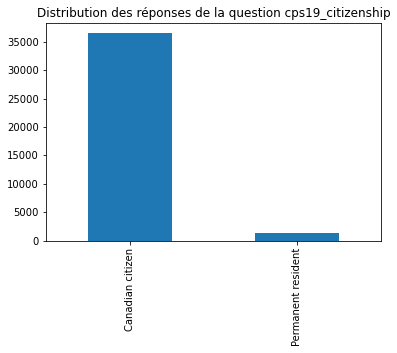

In [21]:
col_of_interest = "cps19_citizenship"
print(df[col_of_interest].value_counts())
plot_column_values(col_of_interest)

### Isoler les questions "étiquette"

In [10]:
label_questions = ['cps19_votechoice', 'cps19_votechoice_pr', 'cps19_vote_unlikely', 'cps19_vote_unlike_pr', 'cps19_v_advance']
label_detail_questions = ['cps19_votechoice_7_TEXT', 'cps19_votechoice_pr_7_TEXT', 'cps19_vote_unlikely_7_TEXT', 'cps19_vote_unlike_pr_7_TEXT', 'cps19_v_advance_7_TEXT', 'cps19_vote_lean', 'cps19_vote_lean_7_TEXT', 'cps19_vote_lean_pr', 'cps19_vote_lean_pr_7_TEXT', 'cps19_2nd_choice', 'cps19_2nd_choice_7_TEXT', 'cps19_2nd_choice_pr', 'cps19_2nd_choice_pr_7_TEXT', 'cps19_not_vote_for_1', 'cps19_not_vote_for_2', 'cps19_not_vote_for_3', 'cps19_not_vote_for_4', 'cps19_not_vote_for_5', 'cps19_not_vote_for_6', 'cps19_not_vote_for_7', 'cps19_not_vote_for_8', 'cps19_not_vote_for_9', 'cps19_not_vote_for_7_TEXT']